In [ ]:
pip install torch transformers accelerate evaluate pandas numpy tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
import time
import os
import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

models = [
    "gpt2",
    "distilgpt2",
    "facebook/opt-350m",
    "EleutherAI/gpt-neo-125M",
    "facebook/opt-125m"
]

test_text = "Artificial intelligence is transforming the world because it allows machines to learn from data and improve over time."

gen_tokens = 50

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def get_model_size_on_disk(model_name):
    from transformers.utils import cached_file
    try:
        weights_file = cached_file(model_name, "pytorch_model.bin")
        return os.path.getsize(weights_file) / (1024 * 1024)
    except:
        return np.nan

def compute_perplexity(model, tokenizer, text):
    encodings = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encodings, labels=encodings["input_ids"])
        loss = outputs.loss
    ppl = torch.exp(loss).item()
    return ppl

results = []

for model_name in tqdm(models, desc="Evaluating models"):
    print(f"\nLoading {model_name} ...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    model.eval()

    num_params = count_parameters(model)
    size_mb = get_model_size_on_disk(model_name)

    inputs = tokenizer(test_text, return_tensors="pt").to(device)

    with torch.no_grad():
        _ = model.generate(**inputs, max_new_tokens=10)

    torch.cuda.synchronize() if device == "cuda" else None
    start = time.time()
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=gen_tokens)
    torch.cuda.synchronize() if device == "cuda" else None
    end = time.time()

    latency = end - start
    tokens_generated = output.shape[1] - inputs["input_ids"].shape[1]
    tokens_per_sec = tokens_generated / latency

    ppl = compute_perplexity(model, tokenizer, test_text)

    results.append({
        "Model": model_name,
        "Params": num_params,
        "Size_MB": size_mb,
        "Latency_s": latency,
        "Tokens_per_s": tokens_per_sec,
        "Perplexity": ppl
    })

df = pd.DataFrame(results)

print("\nRaw Metrics:\n", df)

criteria = ["Params", "Size_MB", "Latency_s", "Tokens_per_s", "Perplexity"]

D = df[criteria].astype(float).values

weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

impacts = np.array([-1, -1, -1, +1, -1])

norm = D / np.sqrt((D**2).sum(axis=0))

V = norm * weights

ideal_best = np.where(impacts == 1, V.max(axis=0), V.min(axis=0))
ideal_worst = np.where(impacts == 1, V.min(axis=0), V.max(axis=0))

S_best = np.sqrt(((V - ideal_best)**2).sum(axis=1))
S_worst = np.sqrt(((V - ideal_worst)**2).sum(axis=1))

topsis_score = S_worst / (S_best + S_worst)

df["TOPSIS_Score"] = topsis_score
df["Rank"] = df["TOPSIS_Score"].rank(ascending=False, method="dense")

df_sorted = df.sort_values(by="TOPSIS_Score", ascending=False)

print("\nTOPSIS Ranking:\n", df_sorted)

df_sorted.to_csv("topsis_text_generation_results.csv", index=False)
print("\nSaved to topsis_text_generation_results.csv")


Evaluating models:   0%|          | 0/5 [00:00<?, ?it/s]


Loading gpt2 ...


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
Evaluating models:  20%|██        | 1/5 [00:03<00:15,  3.94s/it]


Loading distilgpt2 ...


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Evaluating models:  40%|████      | 2/5 [00:07<00:10,  3.50s/it]


Loading facebook/opt-350m ...


Loading weights:   0%|          | 0/388 [00:00<?, ?it/s]

Evaluating models:  60%|██████    | 3/5 [00:11<00:07,  3.99s/it]


Loading EleutherAI/gpt-neo-125M ...


Loading weights:   0%|          | 0/160 [00:00<?, ?it/s]

GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125M
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Evaluating models:  80%|████████  | 4/5 [00:17<00:04,  4.53s/it]


Loading facebook/opt-125m ...


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.decoder.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Evaluating models: 100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


Raw Metrics:
                      Model     Params     Size_MB  Latency_s  Tokens_per_s  \
0                     gpt2  124439808  522.726132   0.432496    115.607987   
1               distilgpt2   81912576  336.488453   0.249187    200.652720   
2        facebook/opt-350m  331196416  631.822259   0.878265     56.930416   
3  EleutherAI/gpt-neo-125M  125198592  501.649259   0.590542     84.667972   
4        facebook/opt-125m  163848192  238.933831   0.385656    129.649101   

   Perplexity  
0   27.900513  
1   38.153831  
2   17.948662  
3   16.350054  
4   25.029409  

TOPSIS Ranking:
                      Model     Params     Size_MB  Latency_s  Tokens_per_s  \
1               distilgpt2   81912576  336.488453   0.249187    200.652720   
4        facebook/opt-125m  163848192  238.933831   0.385656    129.649101   
0                     gpt2  124439808  522.726132   0.432496    115.607987   
3  EleutherAI/gpt-neo-125M  125198592  501.649259   0.590542     84.667972   
2        fac

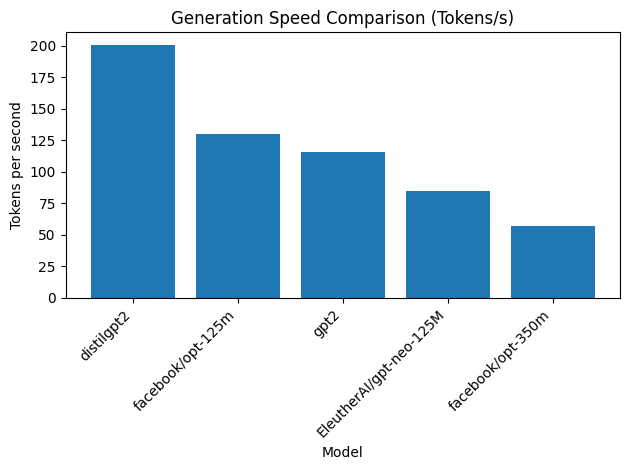

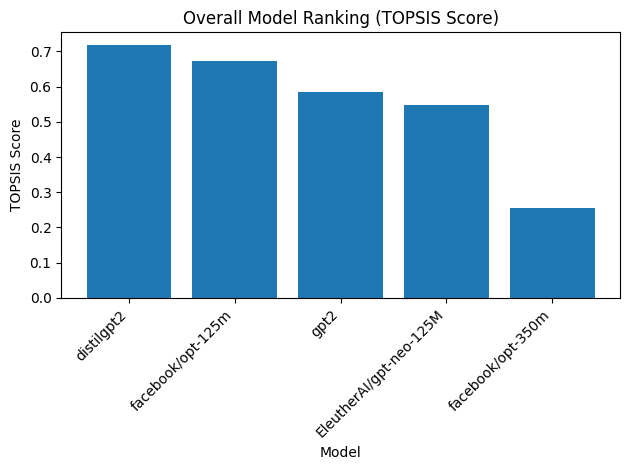

In [13]:
import matplotlib.pyplot as plt

# -------- Graph 1: Tokens per second per model --------
plt.figure()
plt.bar(df_sorted["Model"], df_sorted["Tokens_per_s"])
plt.xlabel("Model")
plt.ylabel("Tokens per second")
plt.title("Generation Speed Comparison (Tokens/s)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# -------- Graph 2: TOPSIS Score per model --------
plt.figure()
plt.bar(df_sorted["Model"], df_sorted["TOPSIS_Score"])
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.title("Overall Model Ranking (TOPSIS Score)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
